In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tradingWithPython as twp
import tradingWithPython.lib.cboe as cboe
import tradingWithPython.lib.yahooFinance as yf
import pandas as pd
twp.extra.setNotebookStyle()

In [3]:
#get data 
symbols = ['SPY', 'VXX', 'VXZ']
priceData = yf.getHistoricData(symbols).minor_xs('adj_close') #数据中包含各种价格，这里只要切一个收盘价的slice
volData = cboe.getHistoricData(['VIX', 'VXV']).dropna()

 [*********************100%***********************]  3 of 3 completeDownloading VIX from http://www.cboe.com/publish/ScheduledTask/MktData/datahouse/vixcurrent.csv


In [4]:
df = priceData.join(volData).dropna() #不同时间index的数据用join合并，然后直接dropna去掉不重合部分分

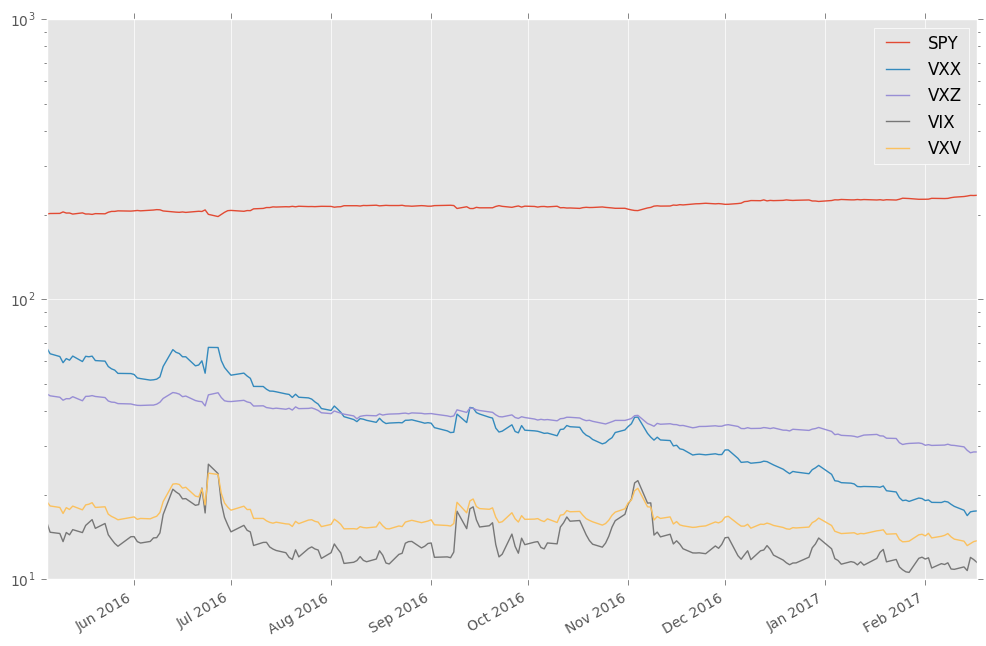

In [5]:
df[-200:].plot(logy=True)

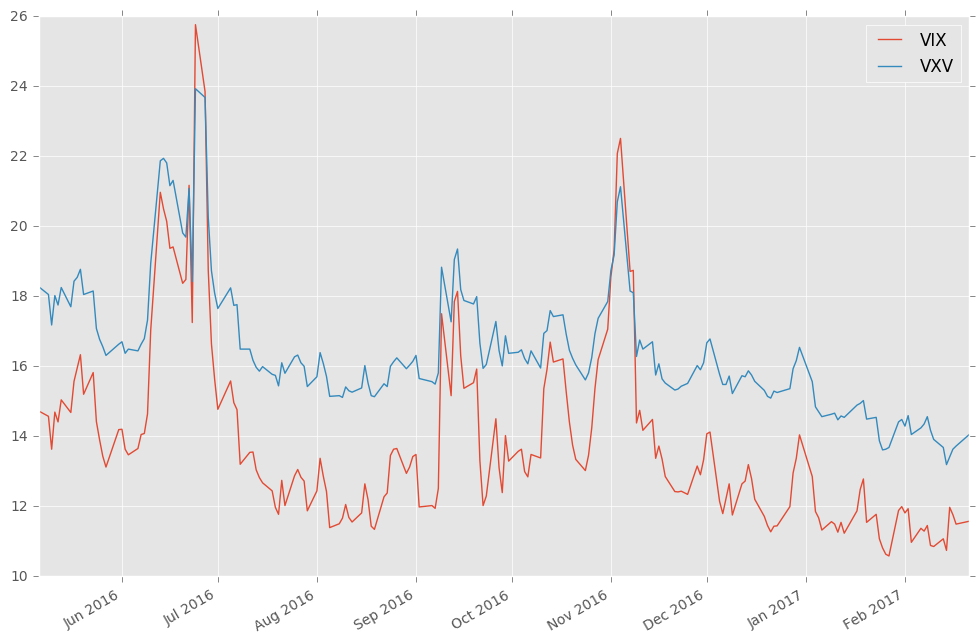

In [6]:
volData[-200:].plot()

## vix是短期波动，vxv是长期波动。两者密切相关。通常情况下，短期波动小于长期波动。time to expiration 越长，波动性应该越大。如果倒挂，那么可能是股票低点 

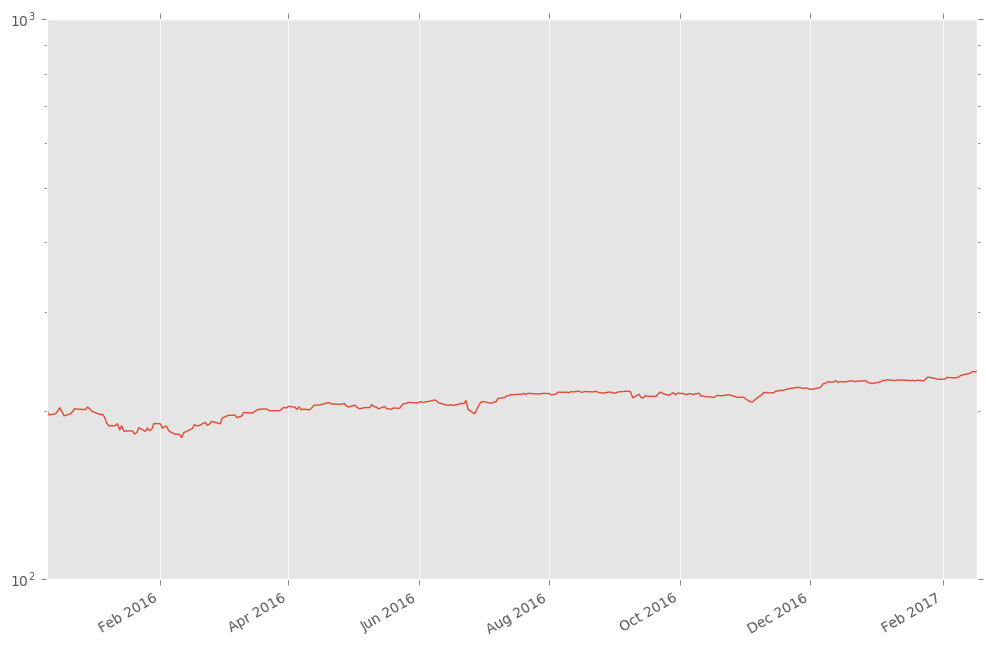

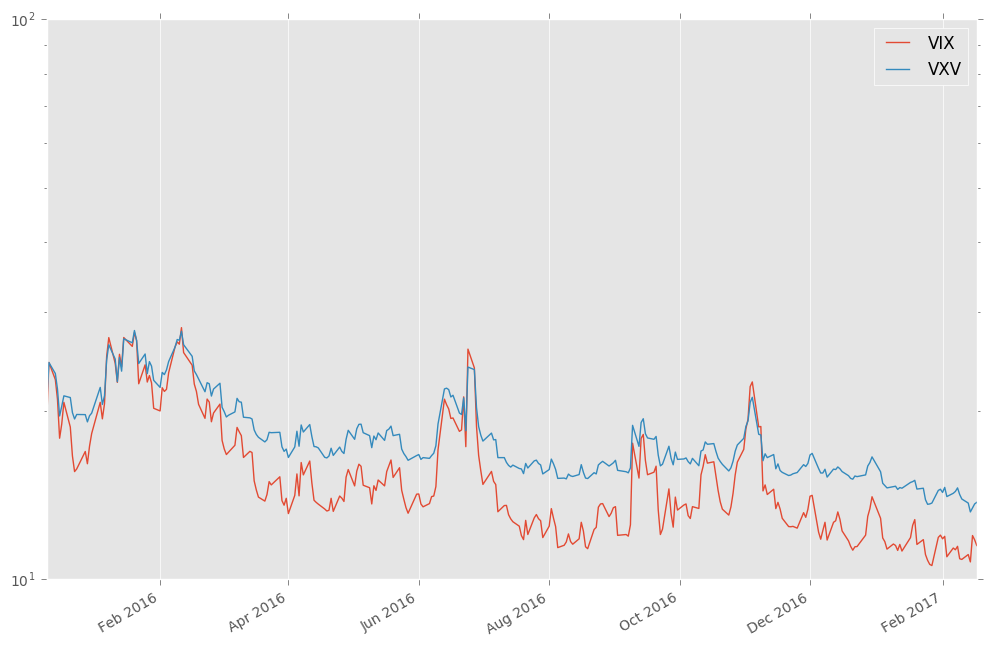

In [7]:
df.ix[-300:,'SPY'].plot(logy=True)
figure()
df.ix[-300:,['VIX', 'VXV']].plot(logy=True)

In [8]:
### 假设VXV是VIX的二次方关系，进行回归

In [9]:
x = volData.VIX.values # 直接调用数据集中的某个列的值，作为自变量
y = volData.VXV.values #变量
order = 2
p = np.polyfit(x, y, order) #p记录回归结果
print('regression coefficientes:', p) #输出回归系数
xx = np.linspace(10, 80)
yy = np.polyval(p, xx)

regression coefficientes: [-0.00363089  1.07293581  1.90564572]


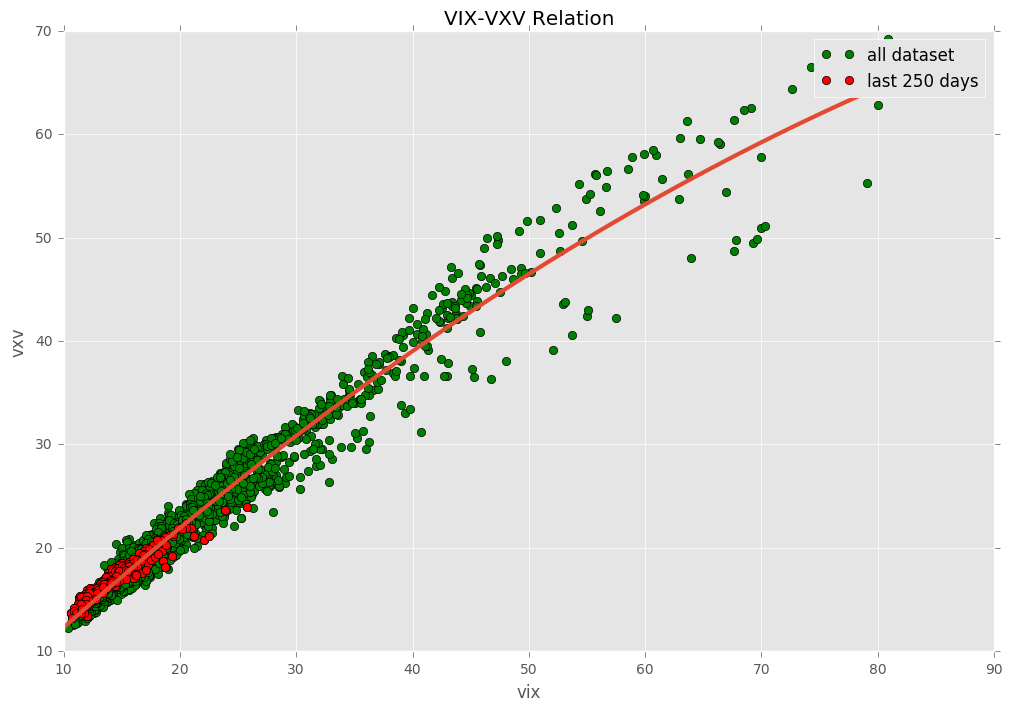

In [10]:
plot(x, y, 'go') #所有历史数据的散点图
w = 250 
plot(x[-w:], y[-w:], 'ro') #最近250天的数据散点图
plot(xx, yy, linewidth=3) #2阶拟合散点连线
grid(True)
legend(('all dataset', 'last %i days' %w))
xlabel('vix')
ylabel('vxv')
title('VIX-VXV Relation')

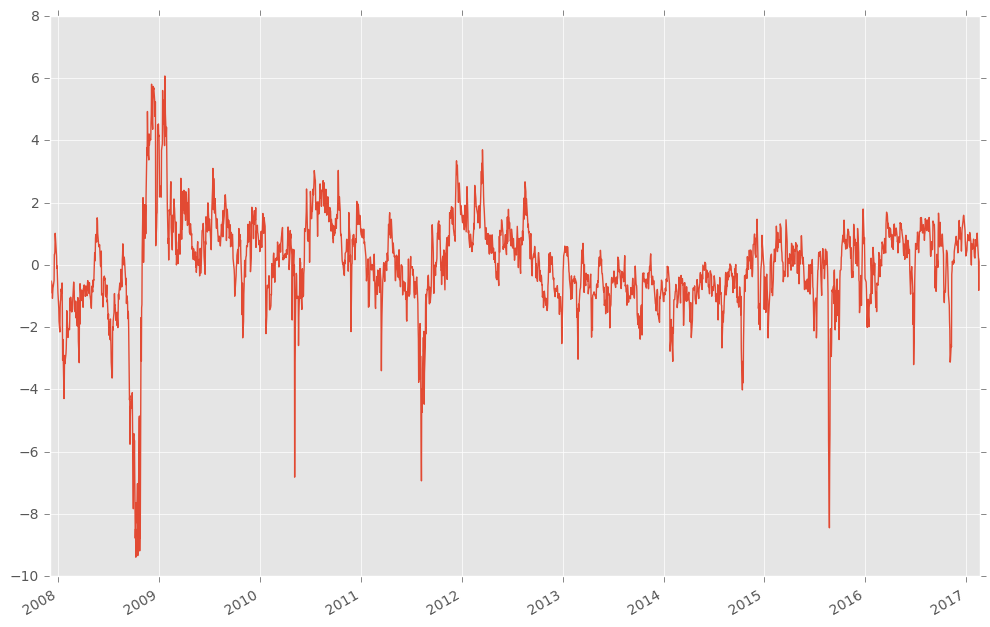

In [11]:
def estimateVXV(vix, p): #根据vix推算vxv
    '''
    function to use regression coefficients to estimate vxv with vix as input
    
    parameters:
    ===========
    vix:pd.Dataframe
        historical value of vix
    
    p:list 
      regression coefficients 
    '''
    vxv = pd.Series(index=vix.index, data=np.polyval(p, vix))
    return vxv

delta = (volData.VXV - estimateVXV(volData.VIX, p)).dropna() #实际的VXV与推算的VXV之间的差额
delta.plot()
grid(True)

In [12]:
PNL = pd.DataFrame(index=delta.index) #建立与delta的index相同的series用来储存pnl结果

In [13]:
#建立若干个交易策略
# dumbVXX strategy 每天卖出VXX，每天balance VXX)是 iPath S&P 500 VIX Short Term Futures TM ETN
ret = df.VXX.pct_change()
pnl = - ret #因为是卖出,所以收益率是负值
PNL['dumbVXX'] = pnl

# spy buy&hold 买入sot持有策略
ret = df.SPY.pct_change() #变量名与上一个策略重复，刷新内存
pnl = ret * 3 # VXX的beta大概是3 
PNL['SPY'] = pnl

#--------smartVXX strategy------------
#VIX/VXV gives a good indication of the steepness of the futures curve, therefore I use it as an indicator for the strategy.
#VXX是一种复杂的产品，由VIX的两种期货组成，两期货的到期时间不同。一个长期，一个远期。 
#VXX每天reblance。将短期期货换成长期期货。也就是roll
#如果远期期货比近期期货贵，也就是contango。那么这种rolling就是赔钱的，VXX的价格就被侵蚀，就赔钱。 
#VIX/VXV的比值对于future的倾斜度有指示作用。所以当VXV过高时，就是比值过低时，越陡峭,远期期货价值越高。赔钱越多，所以要short vxx. 
threshDelta = 0 #确定Delta的有效差值
tradeDir = 1 * (delta > threshDelta) 
#交易方向。 括号里面得到的是布尔值， 如果乘以就变成0或1。 Delta本身就是一个序列。所以tradeDire也是一个序列。
#这样就直接用DF进行了运算，避免在DF内部进行for。效率得到提高。 
tradeDir = -tradeDir.fillna(0) # 反向交易，delta大于阈值卖出
ret = df.VXX.pct_change() #日收益率
pnl = ret * tradeDir.shift(1) #上一交易收盘才知道VXV与预测VXV之间到底是什么关系。这样才能知道第二天的操作方向，获得第二天收益。 
PNL['smartVXX'] = pnl

---sharpe ratio---
dumbVXX         1.18
SPY             1.04
smartVXX        1.74
smartSPY_VXX    1.64
dtype: float64
---profit ratio---
dumbVXX         15.50
SPY             10.13
smartVXX        17.15
smartSPY_VXX    16.35
dtype: float64


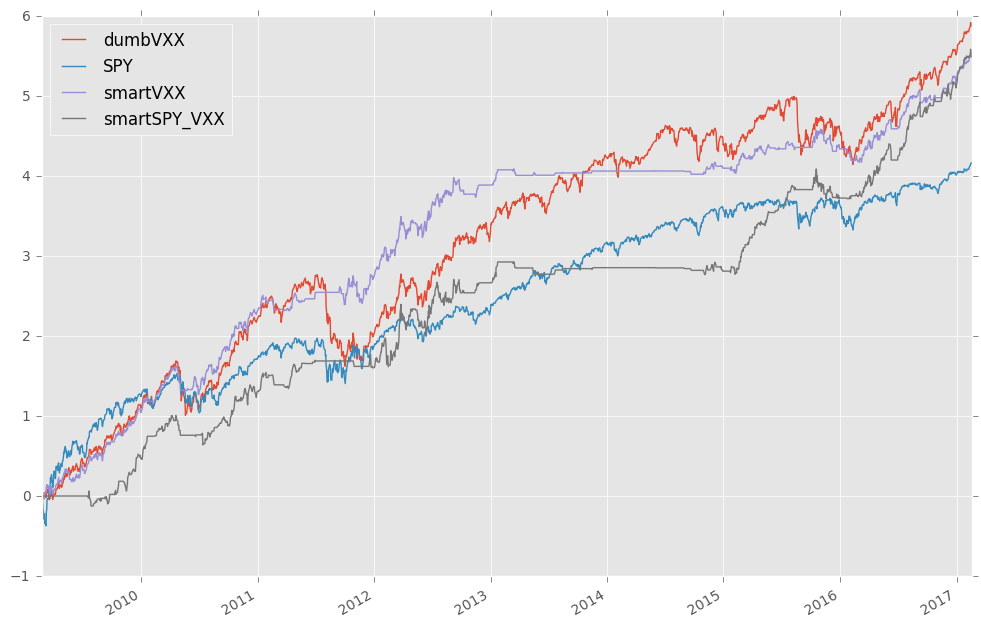

In [14]:
#-----smartSPY_VXX pair策略
# 几乎是market neutral的策略，组合包括 3倍的spy和1倍的VXX， 交易信号相同。 
threshDelta = 0 
ret = df.VXX.pct_change() + 3 * df.SPY.pct_change() #组合整体收益
ret = ret * 2 #加大杠杆， 以便获得与VXX一样的beta
tradeDir = 1 * ((delta > threshDelta) & (df.VIX.reindex(delta.index) < 25)) # delta大于阈值，而且vix小于25
tradeDir = -tradeDir.fillna(0)
pnl = ret * tradeDir.shift(1)
PNL['smartSPY_VXX'] = pnl
PNL = PNL.dropna()
PNL.cumsum().plot()
grid(True)

#-------print statistics
print('---sharpe ratio---')
print(twp.sharpe(PNL))
print('---profit ratio---')
print(twp.profitRatio(PNL))

## It is clear that the strategies using delta are performing much better than VXX and SPY buy-and-hold in terms of return/drawdown. A lower drawdown will enable to increase leverage or simply reduce the stress of watching a portfolio go down.

## 更准确低分析smart vxx策略


In [16]:
#建立一个用vix预测vxv的类
class VXV_estimator(object):
    '''
    class to estimate vxv, using given dataset of vix
       
    '''
    def __init__(self, order=2):
        '''
        Parameters:
        ===========
        self.order: int
            determine the order of regression         
        '''
        self.order = order
        self.p = None
    
    def fit(self, vix, vxv):
        '''
        function to estimate vxv, using given dataset of vix
        Parameter:
        =========
        vix:dataFrame
            historical price of vix
        vxv:dataFrame 
            historical price of vxv
        '''
        vol = pd.DataFrame({'vix':vix, 'vxv':vxv}).dropna()
        x = vix.values #自变量
        y = vxv.values #变量
        self.p = np.polyfit(x, y, self.order) #将回归系数储存到全局变量self.p里面
    
    def estimate(self, vix):
        '''
        function to estimate vxv based on the vix dataset 
        Parameters:
        ===========
        vix:DataFrame
            historical price of vix
        '''
        vxv = pd.Series(index=vix.index, data=np.polyval(self.p, vix))
        return vxv  
 
    
    

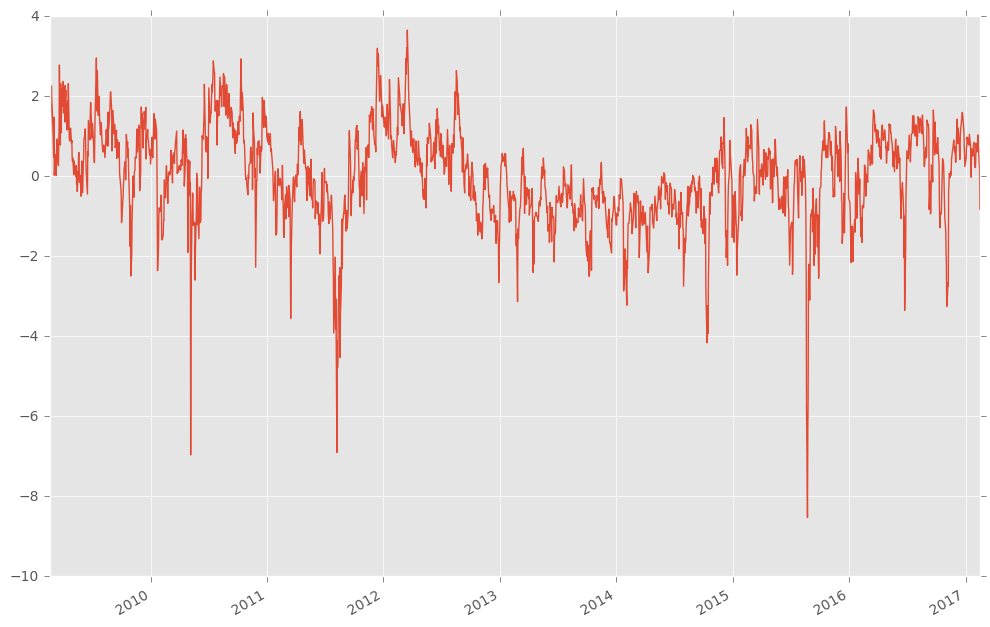

In [17]:
e = VXV_estimator(order=2) #虽然类缺省值是2，但是还是要为order设定一个值
e.fit(df.VIX, df.VXV)
delta = (df.VXV - e.estimate(df.VIX)).dropna()
delta.plot()
grid(True)

In [18]:
#建立一个pos2pnl函数，其结构与twp.tool中的同名函数基本一致
#提供股票价格和仓位数量，给出现金、股票市值、成本，总资产的dataframe。并没有pnl (profit and loss)
#适用于不daily rebalance的情况，适合中国市场。 
def pos2pnl(price, position, ibTransactionCost=False):
    '''
    compute pnl based on price & position
    Parameters:
    ===========
    price: pd.Series 
        historical price of the asset    
    position: pd.Series
        number of shares at each time. Column names must be same as in price
    ibTransactionCost: float
        transaction cost of 0.005$/share
    Output is *cumulative* pnl
    '''
    delta = position.diff() #仓位变化量
    port = pd.DataFrame(index=price.index)
    port['cash'] = (-delta * price).cumsum() #卖出变成cash。price和delta的index应该相同。可以直接乘。 累加。
    port['stock'] = position * price #持有股票的市值
    
    if ibTransactionCost: #如果是true
        tc = -0.005 * position.diff().abs() #交易成本。tc并不是一个单一的格子，而是一个有index的序列
        tc[(tc > -1) & (tc < 0)] = -1 #介于-1和0之间的值都变成-1
        port['tc'] = tc.cumsum() #交易成本也是考虑累计值
    else:
        port['tc'] = 0
        
    port['total'] = port['cash'] + port['stock'] + port['tc']   #只有stock是当次值，其他都是累计值。 
    
    return port

In [21]:
def simulate(vxx,delta, threshDelta = 0, bet=10000):
    ''' simulate smartVXX strategy '''
    
    tradeDir = 1*(delta > threshDelta) # trading direction. 
    
    
    tradeDir = -tradeDir.fillna(0) # fill nans with zeros, '-' is for the short position
    pos = tradeDir*bet/vxx # number of shares held
    
    
    pnl = pos2pnl(vxx,pos, ibTransactionCost=True)
    return pnl

#---test function

pnl = simulate(df.VXX, delta)




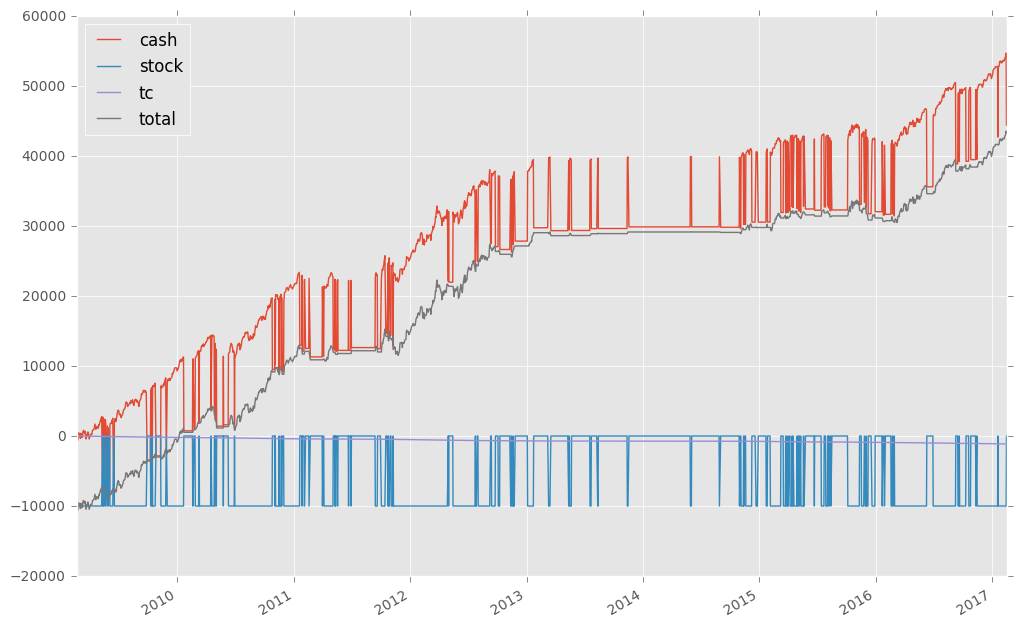

In [23]:
def simulate(vxx, delta, threshDelta=0, bet=10000): #bet代表投资金额
    '''
    模拟smart_VXX策略
    '''
    tradeDir = 1 * (delta>threshDelta) #布尔值变成1或0的序列
    tradeDir = - tradeDir.fillna(0) #应该是反向的
    pos = tradeDir * bet / vxx # 看10000能卖出多少股。 pos是一个序列，卖出，或者归零。并非daily rebalance
    
    pnl = pos2pnl(vxx, pos, ibTransactionCost=True) #得到以cash volum表示的pnl，而且不是 daily rebalance
    
    return pnl 

pnl = simulate(df.VXX, delta)
pnl.plot() #如果符合条件，就short vxx，直到出现清零的信号。计算整个策略的现金，仓位，总市值的曲线。每当short，cash就提高。 